<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_04_auto_ml_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Modeling

In [0]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2'

In [2]:
if COLAB:
  # !sudo apt-get install git-lfs && git lfs install
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  #!cd dl-projects && ls -l --block-size=M

Cloning into 'dl-projects'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 927 (delta 91), reused 14 (delta 8), pack-reused 781
Receiving objects: 100% (927/927), 69.05 MiB | 23.66 MiB/s, done.
Resolving deltas: 100% (539/539), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .

In [0]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib
import sys

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, mean_squared_error, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.ensemble import RandomForestClassifier
#from scikitplot.plotters import plot_precision_recall_curve
from dateutil.relativedelta import relativedelta

from IPython.display import display

from utils import *
from preprocess import *

np.set_printoptions(threshold=sys.maxsize)

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [6]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [7]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.pkl"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 1555M
-rw------- 1 root root 1555M Jan  5 23:01 feature_matrix_d2.pkl
total 1M
-rw-r--r-- 1 root root 1M Jan  6 15:55 4D.zip


In [0]:
#data = pd.read_csv(DATASET, header=0, sep=',', quotechar='"', parse_dates=['time'])
#data = pd.read_csv(DATASET_PATH/"feature_matrix_2.csv", header=0, sep=',', quotechar='"', parse_dates=['time'])
data = pd.read_pickle(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959893 entries, 0 to 959892
Columns: 221 entries, NumberId to year
dtypes: datetime64[ns](1), float64(146), int64(64), uint8(10)
memory usage: 1.5 GB


## Exploratory Data Analysis

In [0]:
feature_matrix = data

In [12]:
display(feature_matrix.columns)

Index(['NumberId', 'time', 'STD(Results.TotalStrike)', 'STD(Results.DrawNo)',
       'STD(Results.LuckyNo)', 'MAX(Results.TotalStrike)',
       'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
       'MIN(Results.TotalStrike)', 'MIN(Results.DrawNo)',
       ...
       'MODE(Results.PrizeType)_3rdPrizeNo',
       'MODE(Results.PrizeType)_Consolation',
       'MODE(Results.PrizeType)_Special', 'LAST(Results.PrizeType)_1stPrizeNo',
       'LAST(Results.PrizeType)_2ndPrizeNo',
       'LAST(Results.PrizeType)_3rdPrizeNo',
       'LAST(Results.PrizeType)_Consolation',
       'LAST(Results.PrizeType)_Special', 'month', 'year'],
      dtype='object', length=221)

In [13]:
display(feature_matrix.head(4).T)

,0,1,2,3
NumberId,72,98,121,166
time,2012-01-01 00:00:00,2012-01-01 00:00:00,2012-01-01 00:00:00,2012-01-01 00:00:00
STD(Results.TotalStrike),0,0,0,0
STD(Results.DrawNo),75380.4,111281,60627.5,104465
STD(Results.LuckyNo),0,0,0,0
...,...,...,...,...
LAST(Results.PrizeType)_3rdPrizeNo,0,0,0,0
LAST(Results.PrizeType)_Consolation,1,1,1,0
LAST(Results.PrizeType)_Special,0,0,0,1
month,1,1,1,1


In [14]:
origin_data[origin_data['LuckyNo']==911].head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo
10287,85495,1995-03-12,ConsolationNo3,911
13607,99896,1996-02-11,SpecialNo10,911
26564,156199,1999-08-29,SpecialNo9,911
30160,171800,2000-08-16,ConsolationNo4,911
65817,326909,2009-12-05,SpecialNo10,911
89716,430815,2015-10-07,SpecialNo3,911
96458,460117,2017-05-27,SpecialNo6,911
102733,487418,2018-12-08,SpecialNo2,911
104575,495419,2019-06-01,SpecialNo4,911
104910,496919,2019-07-03,ConsolationNo4,911


In [0]:
# feature_matrix.groupby('time')['COUNT(Results)'].mean().plot()
# plt.title('Average Monthly Count of Results')
# plt.ylabel('Strike Per Number')

## Feature Selection

In [16]:
from utils import feature_selection

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'NumberId']))

Original shape:  (959893, 219)
0 missing columns with threshold: 90.
42 zero variance columns.
117 collinear columns removed with threshold: 0.95.
Total columns removed:  159
Shape after feature selection: (959893, 60).


In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['NumberId'] = feature_matrix['NumberId']
feature_matrix_selection['Label'] = feature_matrix['Label']

In [19]:
len(feature_matrix_selection.columns), feature_matrix_selection.columns

(63,
 Index(['STD(Results.DrawNo)', 'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
        'TREND(Results.DrawNo, DrawDate)', 'NUM_UNIQUE(Results.PrizeType)',
        'DAY(first_Results_time)', 'MONTH(first_Results_time)',
        'TIME_SINCE(first_Results_time)', 'STD(Results.CUM_SUM(DrawNo))',
        'STD(Results.PERCENTILE(DrawNo))', 'STD(Results.CUM_MEAN(LuckyNo))',
        'MAX(Results.PERCENTILE(DrawNo))', 'MAX(Results.CUM_MEAN(LuckyNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MIN(Results.CUM_MEAN(LuckyNo))', 'MODE(Results.DAY(DrawDate))',
        'MODE(Results.MONTH(DrawDate))', 'MEAN(Results.TIME_SINCE(DrawDate))',
        'MEAN(Results.PERCENTILE(DrawNo))', 'MEAN(Results.CUM_MEAN(LuckyNo))',
        'SKEW(Results.CUM_SUM(DrawNo))', 'SKEW(Results.CUM_MEAN(LuckyNo)

## Correlations

In [0]:
# feature_matrix_selection = feature_matrix

In [21]:
feature_matrix_selection.shape

(959893, 63)

In [22]:
corrs = feature_matrix_selection.corr().sort_values('TotalStrike')
corrs['TotalStrike'].head()

TIME_SINCE(first_Results_time)   -0.002875
MAX(Results.LuckyNo)             -0.002580
NumberId                         -0.002580
STD(Results.DrawNo)              -0.002447
MIN(Results.CUM_MEAN(LuckyNo))   -0.002311
Name: TotalStrike, dtype: float64

In [23]:
corrs['Label'].dropna().tail(15)

TREND(Results.PERCENTILE(LuckyNo), DrawDate)    0.000690
MONTH(first_Results_time)                       0.000858
LAST(Results.CUM_MEAN(LuckyNo))                 0.000988
MAX(Results.CUM_MEAN(LuckyNo))                  0.001007
MEAN(Results.PERCENTILE(DrawNo))                0.001149
LAST(Results.PrizeType)_2ndPrizeNo              0.000914
PERCENTILE(TREND(Results.DrawNo, DrawDate))     0.001007
PERCENTILE(LAST(Results.TotalStrike))           0.001564
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)      0.001496
CUM_SUM(LAST(Results.TotalStrike))              0.001572
MIN(Results.DrawNo)                             0.001718
MAX(Results.PERCENTILE(TotalStrike))            0.002320
STD(Results.CUM_MEAN(LuckyNo))                  0.002349
Label                                           1.000000
TotalStrike                                     0.991808
Name: Label, dtype: float64

In [24]:
corrs['TotalStrike'].dropna().tail(8)

PERCENTILE(LAST(Results.TotalStrike))         0.001387
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)    0.001483
CUM_SUM(LAST(Results.TotalStrike))            0.001747
MIN(Results.DrawNo)                           0.001793
MAX(Results.PERCENTILE(TotalStrike))          0.002124
STD(Results.CUM_MEAN(LuckyNo))                0.002318
Label                                         0.991808
TotalStrike                                   1.000000
Name: TotalStrike, dtype: float64

## Visualization

In [0]:
#pip install autoviz

In [0]:
#from autoviz.AutoViz_Class import AutoViz_Class

### XgBoost

In [0]:
import xgboost as xgb

In [0]:
# https://xgboost.readthedocs.io/en/latest/parameter.html
model = xgb.XGBClassifier(max_depth=50, min_child_weight=1,  n_estimators=200,
                          n_jobs=-1 , verbose=1,learning_rate=0.16, max_delta_step=5)

In [0]:
def predict_dt(dt, feature_matrix, return_probs = False):

    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    print(f"Size of test labels {len(test_labels)}")
    print(f"Size of train labels {len(train_labels)}")
    
    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    print(f"Size of X train {len(X_train)}")
    print(f"Size of X test  {len(X_test)}")
   
    feature_names = list(X_train.columns)
    
    # Impute and scale features
    pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Total positive
    positive = np.where((predictions==1))
    print('Total predicted to be positive: ', len(positive[0]))
  
    # Calculate metrics
    p_score = precision_score(y_test, predictions)
    r_score = recall_score(y_test, predictions)
    f_score = f1_score(y_test, predictions)
    auc_score = roc_auc_score(y_test, probs)
    a_score = accuracy_score(y_test, predictions)
    avg_p_score = average_precision_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    print(f'Precision: {round(p_score, 5)}')
    print(f'Recall: {round(r_score, 5)}')
    print(f'F1 Score: {round(f_score, 5)}')
    print(f'ROC AUC: {round(auc_score, 5)}')
    print(f'Accuracy: {round(a_score, 5)}')
    print(f'Average precision: {round(avg_p_score, 5)}')
    
    print('Confusion matrix')
    print(cm)

    # Total predicted matches
    print('Predicted matches')
    # print(predictions)
    m = np.where((predictions==1))
    print(len(m[0]), m)

    if len(positive[0]) > 0:
      # Matching draws
      print('Matched draws')
      m = np.where((predictions==1) & (y_test==1))
      print(len(m[0]), m)
      month_data = feature_matrix.loc[feature_matrix['date'] == dt]
      numbers = month_data.iloc[m[0]][['NumberId']]
      #print(numbers)
      display(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) & 
                          (origin_data['LuckyNo'].isin(numbers.NumberId))].head(len(positive[0])))                                                   
    else:
      print('No luck this month')                 

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi
    

In [30]:
# All the months
len(feature_matrix_selection['time'].unique()), feature_matrix_selection['time'].unique()

(96, array(['2012-01-01T00:00:00.000000000', '2012-02-01T00:00:00.000000000',
        '2012-03-01T00:00:00.000000000', '2012-04-01T00:00:00.000000000',
        '2012-05-01T00:00:00.000000000', '2012-06-01T00:00:00.000000000',
        '2012-07-01T00:00:00.000000000', '2012-08-01T00:00:00.000000000',
        '2012-09-01T00:00:00.000000000', '2012-10-01T00:00:00.000000000',
        '2012-11-01T00:00:00.000000000', '2012-12-01T00:00:00.000000000',
        '2013-01-01T00:00:00.000000000', '2013-02-01T00:00:00.000000000',
        '2013-03-01T00:00:00.000000000', '2013-04-01T00:00:00.000000000',
        '2013-05-01T00:00:00.000000000', '2013-06-01T00:00:00.000000000',
        '2013-07-01T00:00:00.000000000', '2013-08-01T00:00:00.000000000',
        '2013-09-01T00:00:00.000000000', '2013-10-01T00:00:00.000000000',
        '2013-11-01T00:00:00.000000000', '2013-12-01T00:00:00.000000000',
        '2014-01-01T00:00:00.000000000', '2014-02-01T00:00:00.000000000',
        '2014-03-01T00:00:00.00000

### Prediction by months

In [0]:
from utils import plot_feature_importances

In [32]:
%time june_2019 = predict_dt(pd.datetime(2019,6,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 889893
Size of X train 889893
Size of X test  10000
Training on 889893 observations.
Testing on 10000 observations.

Total predicted to be positive:  0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.51846
Accuracy: 0.9664
Average precision: 0.0336
Confusion matrix
[[9664    0]
 [ 336    0]]
Predicted matches
0 (array([], dtype=int64),)
No luck this month
CPU times: user 3h 47min 48s, sys: 5.35 s, total: 3h 47min 54s
Wall time: 1h 55min 39s


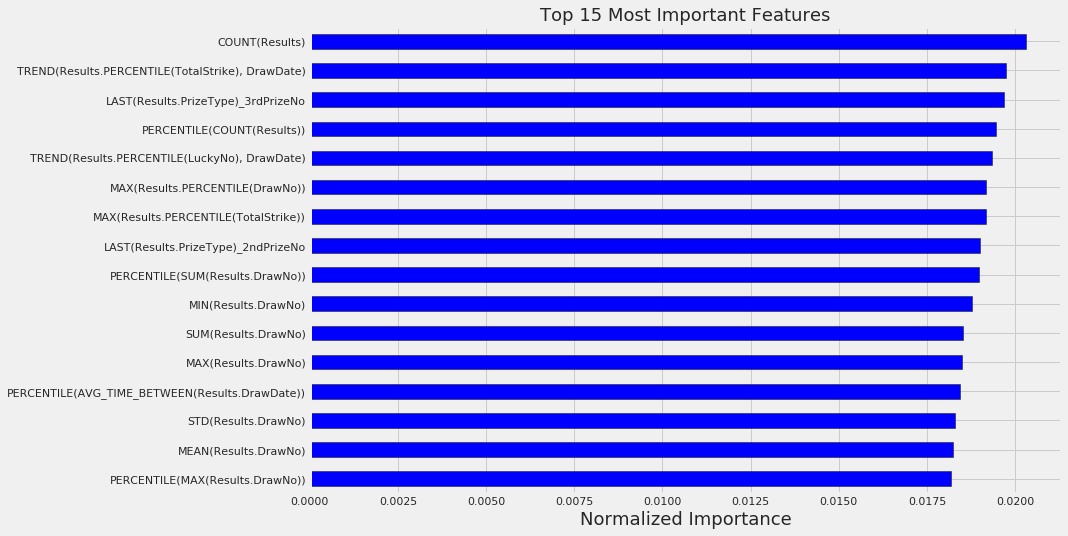

In [33]:
norm_june_2019_fi = plot_feature_importances(june_2019)

In [0]:
## Loop through from June to Dec
start_mt = pd.datetime(2019,6,1)
how_many_mt = 7
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")
  %time predict_dt(month_to_predict, feature_matrix_selection)


2019-06-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 889893
Size of X train 889893
Size of X test  10000
Training on 889893 observations.
Testing on 10000 observations.

Total predicted to be positive:  0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.4984
Accuracy: 0.9664
Average precision: 0.0336
Confusion matrix
[[9664    0]
 [ 336    0]]
Predicted matches
0 (array([], dtype=int64),)
No luck this month
CPU times: user 3min 46s, sys: 178 ms, total: 3min 46s
Wall time: 3min 46s

2019-07-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 899893
Size of X train 899893
Size of X test  10000
Training on 899893 observations.
Testing on 10000 observations.

Total predicted to be positive:  0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.49241
Accuracy: 0.9686
Average precision: 0.0314
Confusion matrix
[[9686    0]
 [ 314    0]]
Predicted matches
0 (array([], dtype=int64),)
No luck this month
CPU times: user 3min 31s

In [0]:
 # %time oct_2019 = predict_dt(pd.datetime(2019,10,1), feature_matrix_selection)

In [0]:
#month_data = feature_matrix_selection.loc[feature_matrix_selection['time'] == pd.datetime(2019,6,1)]
# aa = np.sort(np.array([month_data.NumberId]))
# print(len(aa[0]),aa)
# print(np.array([month_data.NumberId]))
#month_data[month_data['Label'] == 1]['NumberId']

In [0]:
#dd = pd.read_csv(DATASET_PATH/"feature_matrix_2.csv", header=0, sep=',', quotechar='"', parse_dates=['time'])
#prev_data = dd.loc[dd['time'] == pd.datetime(2019,6,1)]
#prev_data[prev_data['Label'] == 1]['NumberId']
#print(np.array([prev_data.NumberId]))

## Check Raw Data

In [0]:
# number = [[128], [511]] 
# d = pd.DataFrame(number, columns = ['NumberId']) 
# d

In [0]:
#display(origin_data[(origin_data['DrawDate'].dt.year == 2019) & (origin_data['DrawDate'].dt.month == 6) & (origin_data['LuckyNo'].isin(d.NumberId))].head(10))

In [0]:
#display(origin_data[(origin_data['DrawDate'].dt.year == 2019) & (origin_data['DrawDate'].dt.month == 10)].head(30))

In [0]:
origin_data[(origin_data['DrawDate'].dt.year == 2019) & (origin_data['DrawDate'].dt.month == 6)]['DrawNo'].nunique()

15

In [0]:
origin_data[(origin_data['DrawDate'].dt.year == 2019) & (origin_data['DrawDate'].dt.month == 10)]['DrawNo'].nunique()

14

In [0]:
print(15 * 23 + 14 * 23)

667



## Parameter Tuning - GridSearchCV